# Ames Housing Data - Housing Price Prediction

### Notebook #3 - Preprocessing Pipeline & Models

Import libraries and helper functions:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn import set_config
set_config(transform_output='pandas')
from category_encoders import OrdinalEncoder

import seaborn as sns

from src.helpers import *

Import data and save as dataframe:

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
# Check the dataframe to ensure data is as expected

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# ---Remove Outliers---

In [4]:
# OutlierRemover is a custom transformer imported from src/helpers.py
# It can remove outliers from multiple columns by specifying the iqr_multipler

# Features where there are significant outliers per EDA
outlier_cols = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea',
                'OpenPorchSF']

# Set the iqr multiplier to 5, to remove only the extreme outliers, in order to keep as much data as possible
outlier_remover = OutlierRemover(columns=outlier_cols,iqr_multiplier=5)

# Fit the dataset to the outlier remover and save to new variable
outlier_remover.fit(df)
df_proc = outlier_remover.transform(df)

# Check how many observations remain
df_proc.count()

Id               1428
MSSubClass       1428
MSZoning         1428
LotFrontage      1178
LotArea          1428
                 ... 
MoSold           1428
YrSold           1428
SaleType         1428
SaleCondition    1428
SalePrice        1428
Length: 81, dtype: int64

# ---Pipeline---

### 1. Filter for features to remove

In [5]:
# Defining the list of columns that will go into the pipeline
# Remove columns that should not be included in the pipeline

# Drop SalePrice b/c target feature
# Drop Id b/c no predictive meaning
# Drop Street b/c feature is invariant, there are 1454 counts of Pave, and only 6 counts of the alternate value, Grvl.
# Drop Utilities b/c feature is invariant, there is only 1 observation that is different from the rest.

all_columns = df.columns.tolist()
columns_remove_from_filter = ['SalePrice','Id','Street','Utilities']

columns_to_keep = [item for item in all_columns if item not in columns_remove_from_filter]

In [6]:
# Preprocessor to filter unwanted columns, or unexpected columns.

preprocessor_filter = ColumnTransformer([
  ('passthrough','passthrough',columns_to_keep)
],remainder='drop', verbose_feature_names_out=False)

### 2. Imputing null variables

In [7]:
# Create a custom transformer for imputing YearRemodAdd and GarageYrBlt with YearBuilt

class YearBuiltImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    X['YearRemodAdd'] = X['YearRemodAdd'].fillna(X['YearBuilt'])
    X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])
    return X


In [8]:
# Preprocessor for imputing all null variables

cols_impute_na = ['Alley', 'GarageType', 'Fence','BsmtQual', 'BsmtCond', 'BsmtExposure',
                  'BsmtFinType1','BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond',
                  'PoolQC', 'MiscFeature']
cols_impute_none = ['MasVnrType']
cols_impute_most_freq = ['MSSubClass','Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','Functional','LotShape',
                         'LandContour','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                         'RoofMatl','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','PavedDrive','MoSold',
                         'YrSold','SaleType','SaleCondition']
cols_impute_median = ['LotArea','OverallQual','OverallCond']
cols_impute_zero = ['LotFrontage', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
                    'GarageCars','GarageArea','2ndFlrSF','LowQualFinSF','GrLivArea','FullBath','HalfBath','PoolArea',
                    'KitchenAbvGr','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal']

preprocessor_imputer = ColumnTransformer([
  ('impute_na', SimpleImputer(strategy='constant', fill_value='NA'), cols_impute_na),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), cols_impute_none),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), cols_impute_zero),
  ('impute_median', SimpleImputer(strategy='median'), cols_impute_median),
  ('impute_most_freq', SimpleImputer(strategy='most_frequent'), cols_impute_most_freq),
  ('impute_year', YearBuiltImputer(), ['YearBuilt','YearRemodAdd','GarageYrBlt']),
], remainder='passthrough', verbose_feature_names_out=False)

### 3. Feature Engineering

In [9]:
# create a custom transformer to incorporate the engineered features into the pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()

    X['YrSold'] = pd.to_numeric(X['YrSold'], errors='coerce')
    X['YearBuilt'] = pd.to_numeric(X['YearBuilt'], errors='coerce')

    X['RatioBathBed'] = (X['FullBath'].fillna(0)+X['HalfBath'].fillna(0)) / (X['BedroomAbvGr'].fillna(0)+1)
    X['HouseAge'] = X['YrSold'] - X['YearBuilt']
    X['TotalBaths'] = X['FullBath'].fillna(0) + (X['HalfBath'].fillna(0)*0.5) + X['BsmtFullBath'].fillna(0) + (X['BsmtHalfBath'].fillna(0)*0.5)
    X['FireBedRatio'] = X['Fireplaces'].fillna(0) / (X['BedroomAbvGr'].fillna(0) + 1)

    X['HouseAge'] = pd.to_numeric(X['HouseAge'], errors='coerce')

    return X


engineer = FeatureEngineer()

### 4. Mapping Ordinal Features

In [10]:
# Defining maps for Ordinal categories

dict_na_ex_6 = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
dict_na_gd_5 = {'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
dict_bsmt = {'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
dict_garage = {'NA':0,'Unf':1,'RFn':2,'Fin':3}
dict_fence = {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
dict_lotshape = {'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}


ordinal_cat_map = [
  {'col':'BsmtQual','mapping':dict_na_ex_6},
  {'col':'BsmtCond','mapping':dict_na_ex_6},
  {'col':'BsmtExposure','mapping':dict_na_gd_5},
  {'col':'BsmtFinType1','mapping':dict_bsmt},
  {'col':'BsmtFinType2','mapping':dict_bsmt},
  {'col':'FireplaceQu','mapping':dict_na_ex_6},
  {'col':'GarageFinish','mapping':dict_garage},
  {'col':'GarageQual','mapping':dict_na_ex_6},
  {'col':'GarageCond','mapping':dict_na_ex_6},
  {'col':'PoolQC','mapping':dict_na_ex_6},
  {'col': 'ExterQual', 'mapping': dict_na_ex_6},
  {'col': 'ExterCond', 'mapping': dict_na_ex_6},
  {'col': 'HeatingQC', 'mapping': dict_na_ex_6},
  {'col': 'KitchenQual', 'mapping': dict_na_ex_6},
  {'col': 'Fence', 'mapping': dict_fence},
  {'col': 'LotShape', 'mapping': dict_lotshape}
  ]

In [11]:
# Log transformation

log_transformer = FunctionTransformer(np.log1p)

# use log1p to handle zeros

preprocessor_log = ColumnTransformer([
  ('log', log_transformer, ['GrLivArea', 'LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
               'WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','PoolArea','MiscVal', 'LowQualFinSF',
               '3SsnPorch'])
], remainder='passthrough', verbose_feature_names_out=False)

### 5. Encoding and Scaling

In [12]:
standard_cols = ['LotFrontage','GarageArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
               'WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','PoolArea','MiscVal', 'LowQualFinSF',
               '3SsnPorch','YearBuilt','YearRemodAdd']

preprocessor_scalers = ColumnTransformer([
  ('standard_scaler', StandardScaler(), standard_cols)
], remainder='passthrough', verbose_feature_names_out=False)

scaler_pipe = Pipeline([
  ('preprocessor_scalers', preprocessor_scalers),
])


In [13]:
# Preprocessor for encoding and scaling

ohe_cols = ['MSSubClass','MSZoning','Alley','LandContour','LotConfig','LandSlope','RoofMatl',
            'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','Exterior1st',
            'Exterior2nd','MasVnrType','Foundation','Heating', 'CentralAir','Electrical','Functional',
            'GarageType','PavedDrive','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']

oe_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
           'BsmtFinType1','BsmtFinType2','HeatingQC','FireplaceQu', 'GarageFinish','GarageQual', 'GarageCond',
           'PoolQC','KitchenQual','Fence','LotShape']


preprocessor_encode_scale = ColumnTransformer([
  ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ohe_cols),
  ('oe', OrdinalEncoder(mapping=ordinal_cat_map), oe_cols)],
  remainder=scaler_pipe, verbose_feature_names_out=False)

# --- Train/Val Split, Fit & Transform ---

In [14]:
# Train/Val split, target feature is SalePrice

X = df.drop(columns='SalePrice')
y = df['SalePrice'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# take the log of the target to normalize the distribution

log_y_train = np.log(y_train)
log_y_val = np.log(y_val)

In [16]:
# Main pipeline, include all preprocessors

main_pipe = Pipeline([
  ('preprocessor_filter', preprocessor_filter),
  ('preprocessor_imputer', preprocessor_imputer),
  ('engineer', engineer),
  ('log', preprocessor_log),
  ('preprocessor_encode_scale', preprocessor_encode_scale)
])

# --- Model Evaluation 1: Lasso ---

In [17]:
# create a pipeline with lasso to use inside of GridSearch

lasso_pipe = Pipeline([
  ('main_pipe', main_pipe),
  ('lasso', Lasso(random_state=42))
])

In [18]:
# lasso_pipe.get_params()

In [19]:
# define the parameters for the GridSearch, then fit the the dataset

params = {
  'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
  'lasso__max_iter': [1000, 5000, 10000]
}

lasso_gs = GridSearchCV(lasso_pipe, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

lasso_gs.fit(X_train, log_y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.268e+00, tolerance: 1.428e-02
  model = cd_fast.enet_coordinate_descent(
/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.013e+00, tolerance: 1.436e-02
  model = cd_fast.enet_coordinate_descent(
/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Obje

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('main_pipe',
                                        Pipeline(steps=[('preprocessor_filter',
                                                         ColumnTransformer(transformers=[('passthrough',
                                                                                          'passthrough',
                                                                                          ['MSSubClass',
                                                                                           'MSZoning',
                                                                                           'LotFrontage',
                                                                                           'LotArea',
                                                                                           'Alley',
                                                                                           'LotShape',
                                                                                           'LandContour',
                                                                                           'LotConfig',
                                                                                           'LandSlope',
                                                                                           'Neighborhood',
                                                                                           'Condition1',
                                                                                           'Condition2',
                                                                                           'BldgType',
                                                                                           'HouseStyle',
                                                                                           'OverallQual',
                                                                                           'Overall...
                                                                                           'BsmtFinType1',
                                                                                           'BsmtFinType2',
                                                                                           'HeatingQC',
                                                                                           'FireplaceQu',
                                                                                           'GarageFinish',
                                                                                           'GarageQual',
                                                                                           'GarageCond',
                                                                                           'PoolQC',
                                                                                           'KitchenQual',
                                                                                           'Fence',
                                                                                           'LotShape'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('lasso', Lasso(random_state=42))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'lasso__max_iter': [1000, 5000, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
# see what were the best parameters

lasso_gs.best_params_

{'lasso__alpha': 0.001, 'lasso__max_iter': 1000}

In [21]:
# calculate the performance metrics on both train and val using the evaluate_regression helper function
# save results to a dataframe for comparison with other models thereafter

results_train = evaluate_regression(lasso_gs, X_train, log_y_train, 'lasso_gs')
results_val = evaluate_regression(lasso_gs, X_val, log_y_val, 'lasso_gs')

In [22]:
# see the results for train

results_train

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.076873,0.013346,26583.674819,0.006415,0.912454,0.90601


In [23]:
# see the results for val

results_val

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.08883,0.017476,27675.380889,0.007472,0.906353,0.870847


In [24]:
# predict val
log_val_preds = lasso_gs.predict(X_val)

# convert prediction back by using exponential
val_preds = np.exp(log_val_preds)

# calculate log RMSE
pred_log = np.log(val_preds)
y_log = np.log(y_val)
root_mean_squared_error(y_log, pred_log)

0.13219630160792176

- The val RMSE is only greater than the train RMSE by $1,091.71, so the variance is fairly small. RMSE is the root mean square error, which calculates the average difference between the actual values and the model's predicted values. Again, the objective is to achieve the lowest log RMSE on the Kaggle test set. Since I don't have the actual target values of the test set, the closest approximation to it will be the log RMSE on my val dataset. For this model, the log RMSE is 0.1322. 

# --- Model Evaluation 2: RandomForest ---

In [25]:
# create a pipeline for the RandomForestRegressor, to use in the GridSearch

from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([
  ('main_pipe', main_pipe),
  ('rf', RandomForestRegressor(random_state=42))
])

In [26]:
# define the parameters for GridSearch, then fit on the train data

params = {
  'rf__n_estimators': [100, 200, 300, 500],
  'rf__max_depth': [None, 5, 10, 15, 20],
  'rf__min_samples_split': [2, 5, 10],
  'rf__min_samples_leaf': [1, 2, 4],
  'rf__max_features': ['sqrt','log2', 0.5, 0.75]
}

rf_gs = GridSearchCV(rf_pipe, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

rf_gs.fit(X_train, log_y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('main_pipe',
                                        Pipeline(steps=[('preprocessor_filter',
                                                         ColumnTransformer(transformers=[('passthrough',
                                                                                          'passthrough',
                                                                                          ['MSSubClass',
                                                                                           'MSZoning',
                                                                                           'LotFrontage',
                                                                                           'LotArea',
                                                                                           'Alley',
                                                                                           'LotShape',
                                                                                           'LandContour',
                                                                                           'LotConfig',
                                                                                           'LandSlope',
                                                                                           'Neighborhood',
                                                                                           'Condition1',
                                                                                           'Condition2',
                                                                                           'BldgType',
                                                                                           'HouseStyle',
                                                                                           'OverallQual',
                                                                                           'Overall...
                                                                                           'Fence',
                                                                                           'LotShape'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10, 15, 20],
                         'rf__max_features': ['sqrt', 'log2', 0.5, 0.75],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
# check the best parameters

rf_gs.best_params_

{'rf__max_depth': 20,
 'rf__max_features': 0.5,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 500}

In [28]:
# add the performance metrics to the dataframe to compare with the previous model

results_train = pd.concat([results_train, evaluate_regression(rf_gs, X_train, log_y_train, 'rf_gs')])
results_val = pd.concat([results_val, evaluate_regression(rf_gs, X_val, log_y_val, 'rf_gs')])

# show the results for train

results_train

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.076873,0.013346,26583.674819,0.006415,0.912454,0.906010
rf_gs,0.033950,0.002612,11433.347191,0.002837,0.982864,0.981603


In [29]:
# show the results for val

results_val

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.088830,0.017476,27675.380889,0.007472,0.906353,0.870847
rf_gs,0.093906,0.020574,29238.479805,0.007908,0.889753,0.847953


In [30]:
# predict val
log_val_preds = rf_gs.predict(X_val)

# convert prediction back by using exponential
val_preds = np.exp(log_val_preds)

# calculate log RMSE
pred_log = np.log(val_preds)
y_log = np.log(y_val)
root_mean_squared_error(y_log, pred_log)

0.14343508922344494

- The RMSE for the RandomForestRegression model is much lower for train than for val. This is a sign of overfitting. Although the model performed much better than the lasso model on the train dataset (RMSE of 11,433 vs. 26,583), the RMSE on the val dataset actually increased. This is also reflected in the val log RMSE, which has increased from 0.1322 to 0.1434. Comparatively, the Lasso model performed better than the RandomForestRegressor model.

# --- Model Evaluation 3: XGBoost ---

In [31]:
# define a pipeline for the XGBRegressor, to be used in the GridSearch

from xgboost import XGBRegressor

xgb_pipe = Pipeline([
  ('main_pipe', main_pipe),
  ('xgb', XGBRegressor(random_state=42))
])

In [32]:
# define the parameters for the GridSearch
# fit on train data

params = {
  'xgb__n_estimators': [100,200,400],
  'xgb__max_depth': [3,5,7],
  'xgb__learning_rate': [0.01, 0.1],
  'xgb__max_depth': [3, 5, 7, 10],
  'xgb__min_child_weight': [3, 5],
  'xgb__subsample': [0.6, 0.8],
  'xgb__colsample_bytree': [0.6, 0.8],
  'xgb__reg_alpha': [0, 0.1, 1],
  'xgb__reg_lambda': [0, 0.1, 1]
}

xgb_gs = GridSearchCV(xgb_pipe, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

xgb_gs.fit(X_train, log_y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('main_pipe',
                                        Pipeline(steps=[('preprocessor_filter',
                                                         ColumnTransformer(transformers=[('passthrough',
                                                                                          'passthrough',
                                                                                          ['MSSubClass',
                                                                                           'MSZoning',
                                                                                           'LotFrontage',
                                                                                           'LotArea',
                                                                                           'Alley',
                                                                                           'LotShape',
                                                                                           'LandContour',
                                                                                           'LotConfig',
                                                                                           'LandSlope',
                                                                                           'Neighborhood',
                                                                                           'Condition1',
                                                                                           'Condition2',
                                                                                           'BldgType',
                                                                                           'HouseStyle',
                                                                                           'OverallQual',
                                                                                           'Overall...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.6, 0.8],
                         'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5, 7, 10],
                         'xgb__min_child_weight': [3, 5],
                         'xgb__n_estimators': [100, 200, 400],
                         'xgb__reg_alpha': [0, 0.1, 1],
                         'xgb__reg_lambda': [0, 0.1, 1],
                         'xgb__subsample': [0.6, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
# check the best parameters

xgb_gs.best_params_

{'xgb__colsample_bytree': 0.6,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 3,
 'xgb__n_estimators': 400,
 'xgb__reg_alpha': 0,
 'xgb__reg_lambda': 1,
 'xgb__subsample': 0.8}

In [34]:
# add the performance metrics to the train and val results tables

results_train = pd.concat([results_train, evaluate_regression(xgb_gs, X_train, log_y_train, 'xgb_gs')])
results_val = pd.concat([results_val, evaluate_regression(xgb_gs, X_val, log_y_val, 'xgb_gs')])

# display the updated table for train

results_train

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.076873,0.013346,26583.674819,0.006415,0.912454,0.906010
rf_gs,0.033950,0.002612,11433.347191,0.002837,0.982864,0.981603
xgb_gs,0.032507,0.001944,8059.690839,0.002714,0.987250,0.986312


In [35]:
# display the updated table for val

results_val

,MAE,MSE,RMSE,MAPE,R2,adj_r2
lasso_gs,0.088830,0.017476,27675.380889,0.007472,0.906353,0.870847
rf_gs,0.093906,0.020574,29238.479805,0.007908,0.889753,0.847953
xgb_gs,0.086700,0.016648,26683.160101,0.007302,0.910788,0.876963


In [36]:
# predict val
log_val_preds = xgb_gs.predict(X_val)

# convert prediction back by using exponential
val_preds = np.exp(log_val_preds)

# calculate log RMSE
pred_log = np.log(val_preds)
y_log = np.log(y_val)
root_mean_squared_error(y_log, pred_log)

0.1290278300746094

- The RMSE for both train and val have decreased, although there is still significant overfitting, as the train RMSE is only $8,059.69, while the val RMSE is $26,683.16. However, the log RMSE has improved, from Lasso's 0.1322 to 0.129. 

# --- Predicting test ---

In [37]:
# import the test data

test_data = pd.read_csv('../data/test.csv')

# save the id column to be added back later to the predictions

test_id = test_data.loc[:,'Id'].copy()
test_id = pd.DataFrame(test_id)

In [38]:
# predict test (keeping in mind it is still log)

log_test_pred = xgb_gs.predict(test_data)
log_test_pred = pd.DataFrame(log_test_pred)

# convert the test predictions back using exponential

test_pred = np.exp(log_test_pred)

# add the id's back to the test predictions and change the column names to match the submission format

combined_test = test_id.join(test_pred)
combined_test.columns = ['Id','SalePrice']

# check the final submission
# combined_test

In [39]:
# save results to csv - submission

combined_test.to_csv('../kaggle_submissions/submission7.csv', index=False)

In [40]:
# calculate kaggle ranking, what percentage I am in

541/3729

0.1450791096808796

# ---Analysis---

### Lasso Model

In [41]:
# check the coefficients for the lasso model to see which variables had the highest coefficients

lasso_index = lasso_gs.best_estimator_.named_steps['lasso'].feature_names_in_
lasso_coef = lasso_gs.best_estimator_.named_steps['lasso'].coef_

In [42]:
# sort the coefficient in descending order
# pd.set_option('display.max_rows', 300)

lasso_coef = pd.Series(lasso_coef, index=lasso_index)
lasso_coef = lasso_coef.abs().sort_values(ascending=False)

In [43]:
# saving the features that have a coefficient of more than 0.01

lasso_point_one = pd.DataFrame(lasso_coef[lasso_coef.values > 0.01])
lasso_point_one = lasso_point_one.reset_index().rename(columns={'index': 'Features'})
lasso_point_one.columns = ['Features','Coefficients']

In [44]:
# check the dataframe

lasso_point_one

,Features,Coefficients
0,GrLivArea,0.309647
1,Neighborhood_StoneBr,0.090292
2,Exterior1st_BrkFace,0.077882
3,Neighborhood_NridgHt,0.077643
4,Neighborhood_Crawfor,0.072103
5,Functional_Typ,0.071045
6,LotArea,0.070961
7,OverallQual,0.057636
8,Neighborhood_NoRidge,0.054425
9,GarageCars,0.048441


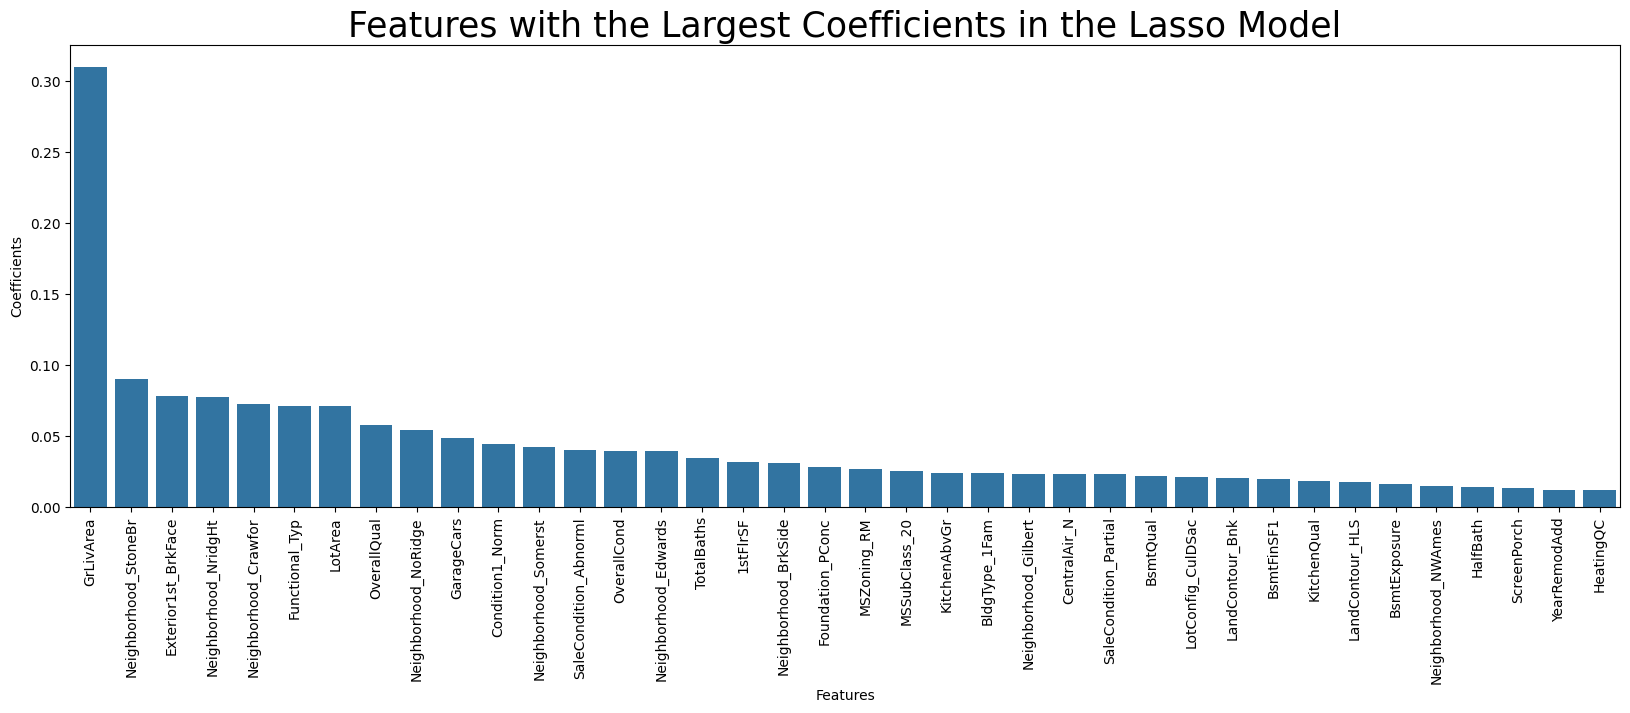

In [45]:
# plot the coefficients that are greater than 0.01

plt.figure(figsize=(20,6))
sns.barplot(data=lasso_point_one, x='Features', y='Coefficients')
plt.xticks(rotation=90)
plt.title('Features with the Largest Coefficients in the Lasso Model', fontsize=25);

- I will analyze all 3 models's highest valued features together at the end

### RandomForest Model

In [46]:
# extract the importance scores from the best model
best_rf_model = rf_gs.best_estimator_
best_rf_model = best_rf_model.named_steps['rf']

# save the features & the importance values to combine later
rf_importances = best_rf_model.feature_importances_
rf_index = best_rf_model.feature_names_in_

# combine the feature name and importance values into a dataframe
rf_important = pd.DataFrame(rf_importances, index=rf_index)
rf_important = rf_important.reset_index()
rf_important.columns = ['Feature','Importance']

# sort the dataframe from highest importance to lowest
rf_important = rf_important.sort_values(by='Importance', ascending=False)

# check the resulting dataframe
rf_important

,Feature,Importance
254,OverallQual,2.808447e-01
245,GrLivArea,1.358963e-01
210,ExterQual,8.570017e-02
260,HouseAge,3.998117e-02
243,YearBuilt,3.367565e-02
...,...,...
81,Condition2_RRAe,4.147496e-07
74,Condition1_RRNe,3.150735e-07
83,Condition2_RRNn,2.396190e-07
82,Condition2_RRAn,2.124507e-07


In [48]:
# get only the features that have an importance of greater than 0.001

rf_zero_one = rf_important[rf_important['Importance'] > 0.001].copy()
rf_zero_one

,Feature,Importance
254,OverallQual,0.280845
245,GrLivArea,0.135896
210,ExterQual,0.085700
260,HouseAge,0.039981
243,YearBuilt,0.033676
232,TotalBsmtSF,0.033264
227,GarageArea,0.032296
261,TotalBaths,0.032270
249,GarageCars,0.030358
233,1stFlrSF,0.027516


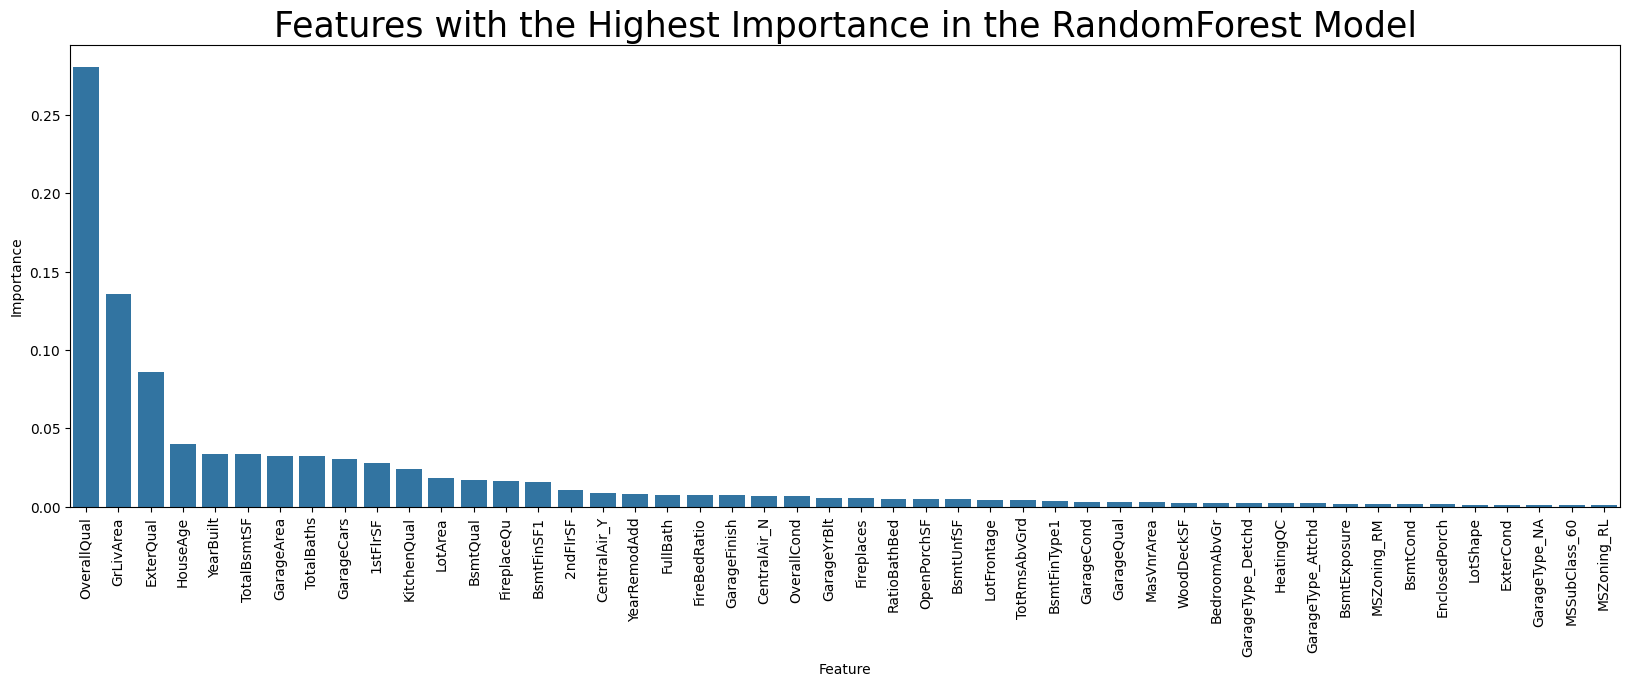

In [49]:
# plot the features that have an importance of greater than 0.001

plt.figure(figsize=(20,6))
sns.barplot(data=rf_zero_one, x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.title('Features with the Highest Importance in the RandomForest Model', fontsize=25);

- I will analyze all 3 models's highest valued features together at the end

### XGBoost Model

In [50]:
# extract the importance scores from the best model

best_xgb_model = xgb_gs.best_estimator_
best_xgb_model = best_xgb_model.named_steps['xgb']
xgb_importance = best_xgb_model.get_booster().get_score(importance_type='gain')

In [51]:
# turn the importance scores into a dataframe
# reset index and rename columns

xgb_importance_df = pd.DataFrame.from_dict(xgb_importance, orient='index')
xgb_importance_df = xgb_importance_df.reset_index()
xgb_importance_df.columns = ['Feature', 'Importance']
xgb_importance_df

,Feature,Importance
0,MSSubClass_20,0.018369
1,MSSubClass_30,0.076791
2,MSSubClass_50,0.028331
3,MSSubClass_60,0.016934
4,MSSubClass_70,0.038804
...,...,...
182,TotRmsAbvGrd,0.057656
183,RatioBathBed,0.025498
184,HouseAge,0.056256
185,TotalBaths,1.097653


In [52]:
# sort the importance in descending order
# include only features with importance greater than 0.01

xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
xgb_point_one = xgb_importance_df[xgb_importance_df['Importance'] > 0.01].copy()
xgb_point_one

,Feature,Importance
178,OverallQual,2.765281
135,ExterQual,2.092568
173,GarageCars,1.402992
167,YearBuilt,1.373718
90,CentralAir_Y,1.238830
...,...,...
165,MiscVal,0.011265
172,BsmtHalfBath,0.010674
141,BsmtFinType2,0.010363
175,HalfBath,0.010304


In [53]:
# there are 169 features with importance of greater than 0.01, narrow down further by importance of greater than 0.10

xgb_point_ten = xgb_importance_df[xgb_importance_df['Importance'] > 0.1].copy()
xgb_point_ten

,Feature,Importance
178,OverallQual,2.765281
135,ExterQual,2.092568
173,GarageCars,1.402992
167,YearBuilt,1.373718
90,CentralAir_Y,1.238830
137,BsmtQual,1.211137
186,FireBedRatio,1.174716
185,TotalBaths,1.097653
169,GrLivArea,0.997011
148,KitchenQual,0.919914


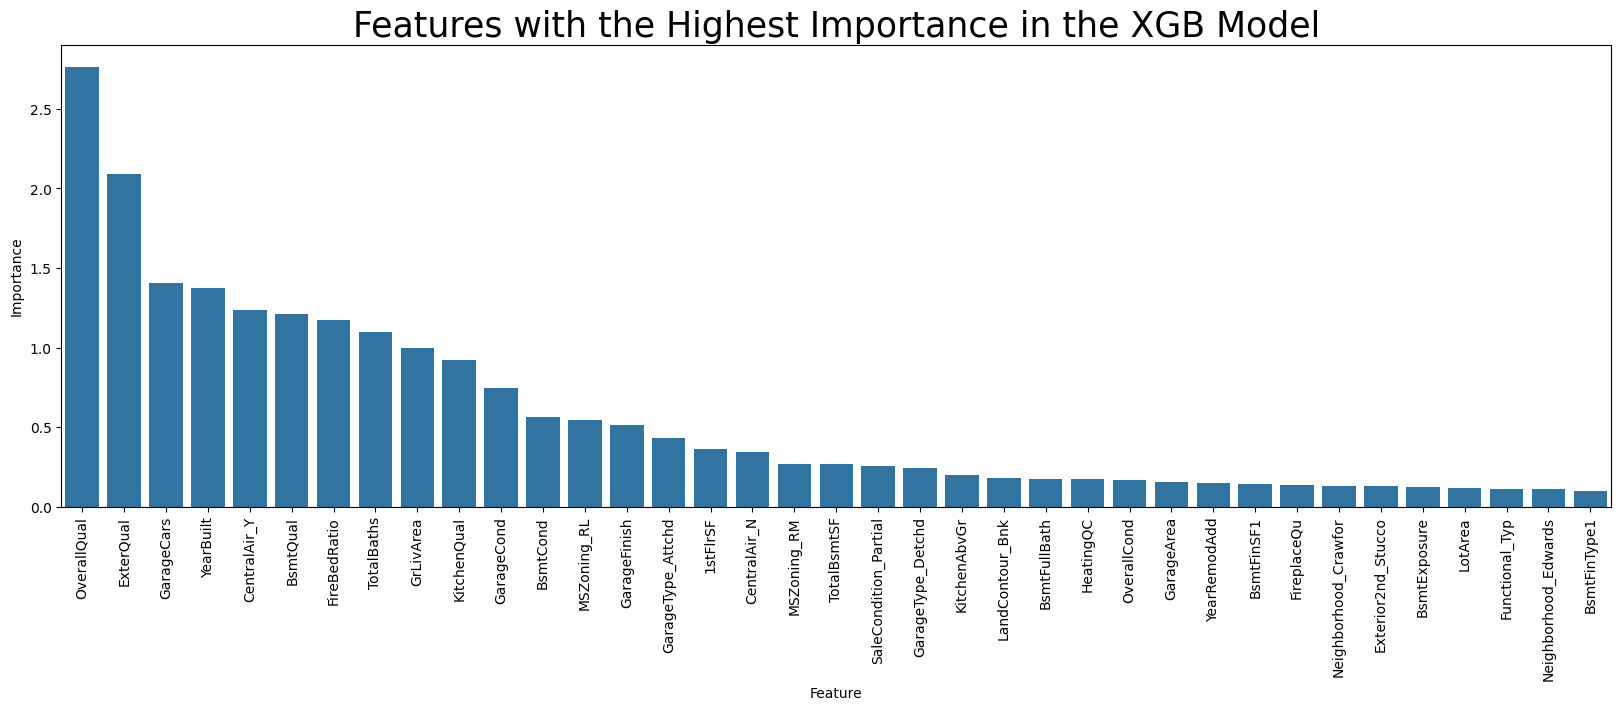

In [54]:
# plot the features by importance

plt.figure(figsize=(20,6))
sns.barplot(data=xgb_point_ten, x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.title('Features with the Highest Importance in the XGB Model', fontsize=25);

### Observations: From the above plots, it is interesting to see which features were deemed to be important in all 3 models, and which ones only appeared in 1 or 2 models.

- OverallQual scored first on both of the ensemble models. This is in line with the original Pearson's correlation coefficient, which also awarded the highest r value to OverallQual. It did not score as high on Lasso, but still the 8th largest coefficient.
- GrLivArea has the largest coefficient by far in the Lasso model, which gave it an coefficient of 0.3096, which is more than triple the the coefficient of the next feature down, Neighborhood_StoneBr with 0.09029. It ranked second on the RF model, and 9th on the XGBoost model. This reaffirms my initial observations that the size of the home highly correlated with the sale price.
- Some of my engineered features were found to be important by the models. HouseAge is the 4th most important in the RF model, and TotalBaths 8th. The XGB model also valued TotalBaths at 8th most importance, but it deemed FireBedRatio to be even more telling! FireBedRatio came in as the 7th most important feature according to XGBoost.
- The Lasso model seemed to emphasize the various neighborhoods more, with the 2nd, 4th and 5th features all being specific neighborhoods. This makes sense though, as the initial correlation also showed Neighborhood having the second highest correlation coefficient to SalePrice. To the contrary, the ensemble models did not assign as high of an importance to any of the neighborhood, they are further down the list.